In [113]:
import pandas as pd
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
df_andenes_ute = pd.read_csv('logs/cansat_real.txt', sep=',')
df_andenes_inne = pd.read_csv('logs/cansat_launch.txt', sep=',')
df_spaceport = pd.read_csv('logs/log.txt', sep=',')
print(df_andenes_ute)

     elapsed_time    id      time     alt        lat        lng   pressure  \
0          0:2:33   945   14:6:23    83.4  69.295898  16.029207  100392.11   
1          0:2:35   946   14:6:25    87.6  69.295914  16.029295  100245.01   
2          0:2:40   948   14:6:30    98.8  69.295929  16.029293   99981.00   
3          0:2:42   949   14:6:32   106.6  69.295860  16.029194   99887.51   
4          0:2:46   951   14:6:36   116.4  69.295937  16.028976   99697.45   
...           ...   ...       ...     ...        ...        ...        ...   
1575      1:19:33  3066  15:23:23  4120.1  69.606560  15.663271   59232.73   
1576      1:19:39  3069  15:23:29  4032.2  69.607231  15.663172   59871.40   
1577      1:19:41  3070  15:23:31  4007.6  69.607452  15.663124   60090.14   
1578      1:19:44  3071  15:23:33  3982.7  69.607674  15.663103   60322.62   
1579      1:19:52  3075  15:23:42  3871.7  69.608627  15.663056   61217.25   

           ohm      hum     co2     temp  rssi  
0     22618.76

In [114]:

df_merged = pd.merge(df_spaceport, df_andenes_ute, on=['elapsed_time','id','time','alt','lat','lng','pressure','ohm','hum','co2','temp','rssi'], how='outer')  # Merge df1 and df2
df_merged = pd.merge(df_merged, df_andenes_inne, on=['elapsed_time','id','time','alt','lat','lng','pressure','ohm','hum','co2','temp','rssi'], how='outer')  # Merge the result with df3

# The "how='outer'" parameter ensures that all unique values from each dataset are included in the merged dataset without overlapping the same values

df_merged = df_merged.sort_values('id')

df_merged.drop_duplicates(subset=['id'], inplace=True)

# Display the merged dataset
df_merged.to_csv('merged_data.txt', index=False, sep=',')


Packets lost at Spaceport:212
Packets lost at Andenes inside:129
Packets lost at Andenes outside:359
Packets lots in total: 54


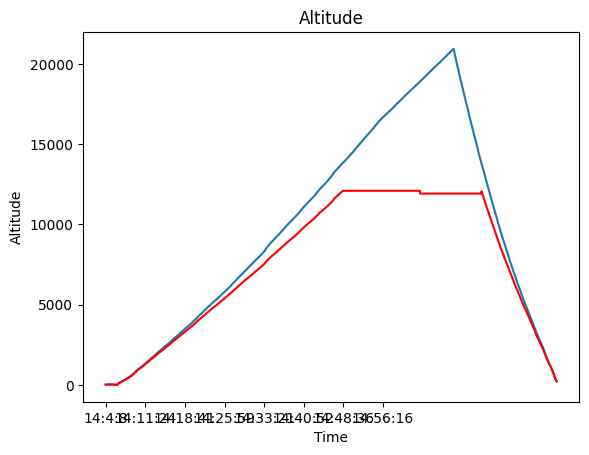

In [115]:

df_andenes_ute['loss'] = df_andenes_ute['id'].diff()
df_andenes_inne['loss'] = df_andenes_inne['id'].diff()
df_spaceport['loss'] = df_spaceport['id'].diff()
df_merged['loss'] = df_merged['id'].diff()

loss_au = df_andenes_ute[df_andenes_ute['loss'] > 1]
loss_ai = df_andenes_inne[df_andenes_inne['loss'] > 1]
loss_sp = df_spaceport[df_spaceport['loss'] > 1]
loss = df_merged[df_merged['loss'] > 1]
# plot

print(f"Packets lost at Spaceport:{len(loss_sp.index)}")
print(f"Packets lost at Andenes inside:{len(loss_ai.index)}")
print(f"Packets lost at Andenes outside:{len(loss_au.index)}")
print(f"Packets lots in total: {len(loss.index)}")
R = 8.31446261815324
T0 = 278.15
g = 9.80665
M = 0.0289644
P0 = 101325
P = df_merged['pressure']

altitude = (R*T0/(g*M))*np.log(P0/P)

plt.xticks(np.arange(0,1597, 200))
plt.plot(df_merged['time'], altitude)
plt.plot(df_merged['time'], df_merged['alt'], 'r')
# plt.plot(df_merged['time'], df_merged['pressure'], 'g')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude')
plt.show()

# plt.xticks(np.arange(0,1597, 200))
# plt.scatter(loss_au.index, loss_au['loss'], s=2)
# plt.xlabel('Index')
# plt.ylabel('Packets lost')
# plt.title('Signal loss Andenes Ute')
# plt.show()
# plt.scatter(loss_ai.index, loss_ai['loss'], s=2)
# plt.xlabel('Index')
# plt.ylabel('Packets lost')
# plt.title('Signal loss Andenes Inne')
# plt.show()
# plt.scatter(loss_sp.index, loss_sp['loss'], s=2)
# plt.xlabel('Index')
# plt.ylabel('Packets lost')
# plt.title('Signal loss Spaceport')
# plt.show()
# plt.scatter(loss.index, loss['loss'], s=2)
# plt.xlabel('Index')
# plt.ylabel('Packets lost')
# plt.title('Signal lost total')
# plt.show()


# plt.plot(x, id)


# plt.show()